In [1]:
%cd ..

/Users/brewer/Code/UU/CS6390/litbank-entities


# explore

In [2]:
import operator
import os

import numpy as np
from matplotlib import pyplot as plt

from litbank_entities import linguistics, litbank

Download data set, if needed.

In [3]:
if not os.path.exists(litbank.SRC_PATH_DEFAULT):
    ! git clone https://github.com/dbamman/litbank.git ./litbank/
else:
    print('litbank repository found in `./litbank/`.')

litbank repository found in `./litbank/`.


Verify that each text has a corresponding **annotation**, **txt** and **tsv** file.

In [4]:
ann_paths = litbank.get_ann_paths()
txt_paths = litbank.get_txt_paths()
assert len(ann_paths) == len(txt_paths)

tsv_paths = litbank.get_tsv_paths()
assert len(tsv_paths) == len(ann_paths)

for i, ann_path in enumerate(ann_paths):
    basename = os.path.basename(ann_path)
    name = basename[:basename.index('.')]
    assert os.path.basename(txt_paths[i]).startswith(name)
    assert os.path.basename(tsv_paths[i]).startswith(name)

print('Found {:d} aligned texts.'.format(len(ann_paths)))

Found 100 aligned texts.


## Annotations

Verify:

- Entity category names in the data set are legitimate.
- Phrase indices are precise.

In [5]:
text_category_token_counts = list()
text_annotations = litbank.get_text_annotations()
texts = litbank.get_texts()
for i, annotations in enumerate(text_annotations):
    text = texts[i]
    category_token_counts = [0 for _ in range(len(litbank.ENTITY_CATEGORIES))]
    for id_, category, a, b, phrase in annotations:
        assert category in litbank.ENTITY_CATEGORY_SET
        assert text[a:b] == phrase
        category_token_counts[litbank.ENTITY_CATEGORY_TO_INDEX[category]] += len(phrase.split(' '))
    text_category_token_counts.append(category_token_counts)

How many of each kind of entity are found?

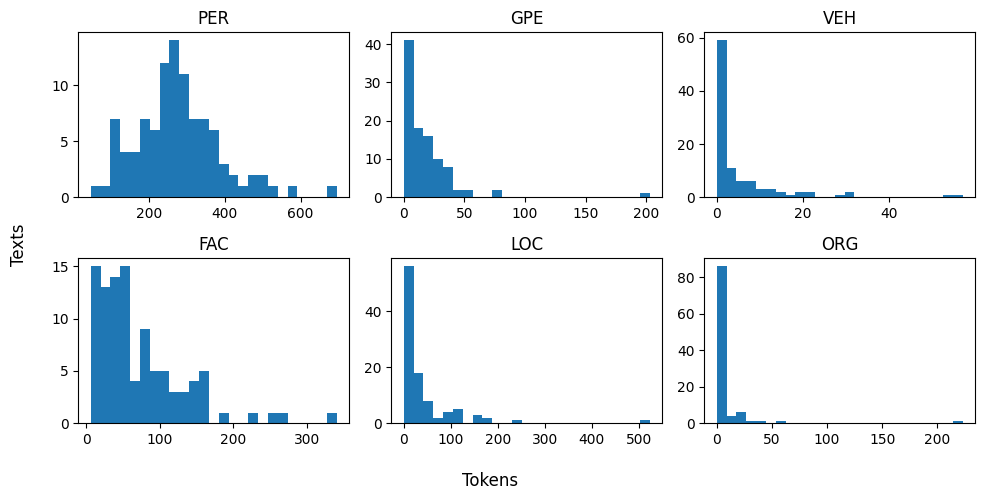

In [6]:
category_text_token_counts = list(zip(*text_category_token_counts))

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, text_token_counts in enumerate(category_text_token_counts):
    ax = axes[i%2][i//2]
    ax.hist(text_token_counts, bins=25)
    ax.set_title(litbank.ENTITY_CATEGORIES[i])
fig.supylabel('Texts')
fig.supxlabel('Tokens')
fig.tight_layout()
plt.show()

How many of each type of entity are present?

In [7]:
total_category_token_counts = list(map(sum, category_text_token_counts))
for i, token_count in enumerate(total_category_token_counts):
    print('{:<{w}} {:>5d}'.format(litbank.ENTITY_CATEGORIES[i], token_count, w=max(map(len, litbank.ENTITY_CATEGORIES))))

PER 27689
FAC  7309
GPE  1817
LOC  4127
VEH   528
ORG   623


## Labels

Ensure that annotations never cross sentence boundaries.

In [8]:
text_sentence_tokens, text_sentence_labels = litbank.get_text_sentence_tokens_labels()

assert not any(any(any(nest_label.startswith('I') for nest_label in labels[0])
                   for labels in text_sentence_labels[i])
               for i in range(len(text_sentence_labels)))

What is the maximum allocated (i.e., by the data set) nested tag depth for each text?

(array([4, 5]), array([88, 12]))


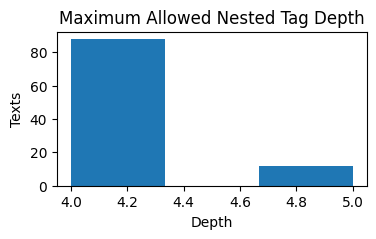

In [9]:
text_depth = np.array([len(sentence_labels_[0][0]) for sentence_labels_ in text_sentence_labels])
print(np.unique(text_depth, return_counts=True))

plt.figure(figsize=(4, 2))
plt.hist(text_depth, bins=3)
plt.title('Maximum Allowed Nested Tag Depth')
plt.ylabel('Texts')
plt.xlabel('Depth')
plt.show()

But are they actually all used? What is the maximum USED nested tag depth for each text?

(array([2., 3., 4.]), array([32, 56, 12]))


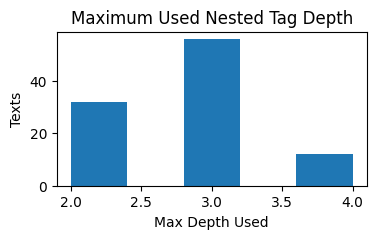

In [10]:
text_depth_used = np.zeros(len(text_sentence_labels))
for i in range(len(text_sentence_labels)):
    depth_used_max = 0
    for labels in text_sentence_labels[i]:
        for label in labels:
            depth_used_max = max(depth_used_max, sum(1 if nest_label != 'O' else 0 for nest_label in label))
    text_depth_used[i] = depth_used_max

print(np.unique(text_depth_used, return_counts=True))

plt.figure(figsize=(4, 2))
plt.hist(text_depth_used, bins=5)
plt.title('Maximum Used Nested Tag Depth')
plt.ylabel('Texts')
plt.xlabel('Max Depth Used')
plt.show()

It would be easy if we could build a model to look for one entity type at a time, but, unfortunately, an entity phrase can be nested within another phrase of the same type. How often does this occur?

In [11]:
category_to_nested_spans = {category: list() for category in litbank.ENTITY_CATEGORIES}
for i, annotations in enumerate(text_annotations):
    category_to_spans = {category: list() for category in category_to_nested_spans.keys()}
    for annotation in annotations:
        _, category, a, b, phrase = annotation
        category_to_spans[category].append((a, b, phrase))
    for category in category_to_spans.keys():
        spans = sorted(category_to_spans[category])
        for j in range(1, len(spans)):
            a, b, phrase = spans[j-1]
            a_, b_, phrase_ = spans[j]
            if a_ <= b:
                category_to_nested_spans[category].append(((a, b), (a_, b_), phrase, phrase_))

for category, nested_spans in category_to_nested_spans.items():
    print(category, len(nested_spans))

PER 1124
FAC 97
GPE 13
LOC 75
VEH 0
ORG 3


## Tokens

How many total tokens are found in each text?

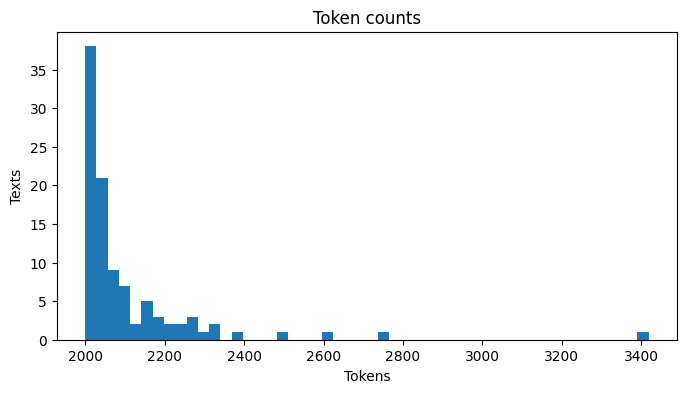

In [12]:
text_tokens = [sum(len(tokens) for tokens in text_sentence_tokens[i]) for i in range(len(text_sentence_tokens))]
assert sum(text_tokens) == 210_532

plt.figure(figsize=(8, 4))
plt.hist(text_tokens, bins=50)
plt.title('Token counts')
plt.ylabel('Texts')
plt.xlabel('Tokens')
plt.show()

"Flatten" the array of tokens per sentence per text - that is, create a unified array of tokens per sentence.

In [13]:
sentence_tokens, sentence_labels = litbank.flatten_texts(text_sentence_tokens, text_sentence_labels)
len(sentence_tokens), len(sentence_labels)

(8562, 8562)

How long are the semantic sequences (sentences) that we will likely feed to a model?

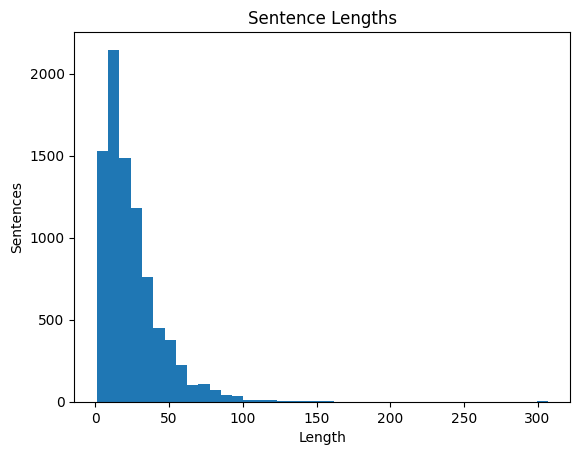

In [14]:
sentence_lengths = [len(tokens) for tokens in sentence_tokens]

plt.hist(sentence_lengths, bins=40)
plt.title('Sentence Lengths')
plt.ylabel('Sentences')
plt.xlabel('Length')
plt.show()

Can we break up the long sentences using a token delimiter to make sequences more manageable?

For example, we would hope that a conjunctive semi-colon would be present near the middle of a large sentence, and that that semi-colon is not a part of any entity tag.

In [15]:
sentence_tokens_labels_sorted = sorted(list(zip(sentence_tokens, sentence_labels)), key=lambda t: len(t[0]), reverse=True)
for i, (tokens, labels) in enumerate(sentence_tokens_labels_sorted[:2]):
    delims = [';', 'but', 'and']
    delim_to_indices = {delim: [j for j, token in enumerate(tokens)
                                if token == delim and all(nest_label == 'O' for nest_label in labels[j])]
                        for delim in delims}
    print(i)
    print(len(tokens))
    for delim in delims:
        print(delim, delim_to_indices[delim])
    print(' '.join(tokens))
    print()

0
307
; [53, 123, 142, 154, 184, 263, 287]
but [27, 264]
and [6, 37, 64, 137, 145, 170, 191, 197, 239, 276, 294]
He bade me observe it , and I should always find that the calamities of life were shared among the upper and lower part of mankind , but that the middle station had the fewest disasters , and was not exposed to so many vicissitudes as the higher or lower part of mankind ; nay , they were not subjected to so many distempers and uneasinesses , either of body or mind , as those were who , by vicious living , luxury , and extravagances on the one hand , or by hard labour , want of necessaries , and mean or insufficient diet on the other hand , bring distemper upon themselves by the natural consequences of their way of living ; that the middle station of life was calculated for all kind of virtue and all kind of enjoyments ; that peace and plenty were the handmaids of a middle fortune ; that temperance , moderation , quietness , health , society , all agreeable diversions , and a

### Vocabulary

In [16]:
v = linguistics.get_vocabulary(sentence_tokens)
print(len(v))
v[:10] + v[-10:]

17868


[(',', 13747),
 ('the', 9798),
 ('.', 7524),
 ('and', 6025),
 ('of', 5906),
 ('a', 4583),
 ('to', 4455),
 ('in', 3043),
 ('I', 2719),
 ('was', 2619),
 ('12', 1),
 ('11th', 1),
 ('10', 1),
 ('02', 1),
 ('01', 1),
 ('*****', 1),
 ("'Cause", 1),
 ('$', 1),
 ('!!!', 1),
 ('!!', 1)]

Observe [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law).

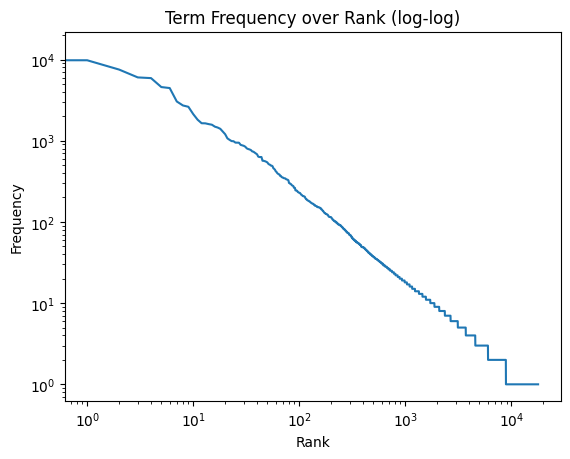

In [17]:
plt.plot(list(range(len(v))), list(zip(*v))[1])
plt.title('Term Frequency over Rank (log-log)')
plt.ylabel('Frequency')
plt.xlabel('Rank')
plt.yscale('log')
plt.xscale('log')
plt.show()

Which tokens, if any, should be converted to lower-case?

In [18]:
token_to_count = dict(v)
complements = list()
for token, count in v:
    lower = token.lower()
    if token == lower:
        continue
    if lower not in token_to_count.keys():
        continue
    complements.append((lower, token, token_to_count[lower], count, token_to_count[lower] / count))
complements.sort(key=operator.itemgetter(4))

print(len(complements))
complements[:5] + complements[-5:]

1289


[('i', 'I', 2, 2719, 0.000735564545788893),
 ('buck', 'Buck', 1, 31, 0.03225806451612903),
 ('tom', 'Tom', 1, 29, 0.034482758620689655),
 ('miss', 'Miss', 5, 142, 0.035211267605633804),
 ('chapter', 'CHAPTER', 2, 56, 0.03571428571428571),
 ('not', 'NOT', 948, 1, 948.0),
 ('and', 'AND', 6025, 6, 1004.1666666666666),
 ('for', 'FOR', 1204, 1, 1204.0),
 ('it', 'IT', 1575, 1, 1575.0),
 ('that', 'THAT', 2128, 1, 2128.0)]

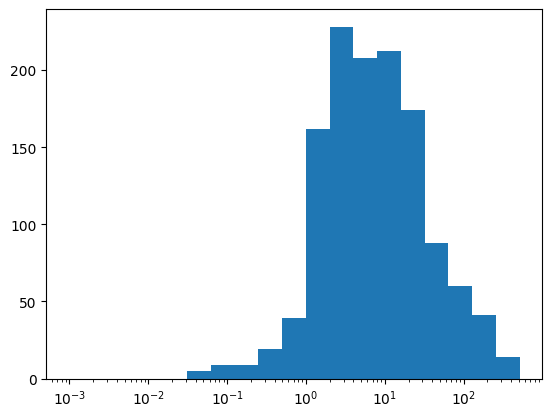

In [19]:
plt.hist([complement[4] for complement in complements], bins=[2**p for p in range(-10, 10)])
plt.xscale('log')
plt.show()